In [11]:
import pandas as pd

In [12]:
pixels = pd.read_csv("../image_flat/flattened_images.csv")
train_metadata = pd.read_csv("../train/train_metadata.csv")
merged_df = pixels.merge(train_metadata, on='image_path')
hog_pca = pd.read_csv("../train/Features/hog_pca.csv")
color_hist = pd.read_csv("../train/Features/color_histogram.csv")
additional_features = pd.read_csv("../train/Features/additional_features.csv")
digits = pd.read_csv("../dig_feature/ocr_digit_detection.csv")

# Base dataframe
merged_df = pixels.merge(train_metadata, on='image_path')

# Merge with feature sets (on image_path)
merged_df = merged_df.merge(hog_pca, on='image_path')
merged_df = merged_df.merge(color_hist, on='image_path')
merged_df = merged_df.merge(additional_features, on='image_path')
merged_df = merged_df.merge(digits, on='image_path')


# display(merged_df)



In [13]:
print(len(merged_df.columns))

1157


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split dataset first
train_df, test_df = train_test_split(
    merged_df, 
    test_size=0.2, 
    stratify=merged_df['ClassId'], 
    random_state=42
)

# Features to normalize (exclude keys and target)
features = train_df.columns.difference(['image_path', 'ClassId'])

# Initialize scaler
scaler = StandardScaler()

# Fit scaler on train features only
scaler.fit(train_df[features])

# Convert columns to float before assignment
train_df[features] = train_df[features].astype(float)
test_df[features] = test_df[features].astype(float)

# Now assign the scaled values
train_df.loc[:, features] = scaler.transform(train_df[features])
test_df.loc[:, features] = scaler.transform(test_df[features])

# Extract X and y
X_train = train_df.drop(['image_path', 'ClassId'], axis=1).values
y_train = train_df['ClassId'].values

X_test = test_df.drop(['image_path', 'ClassId'], axis=1).values
y_test = test_df['ClassId'].values

In [15]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split into train/test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model
clf = MLPClassifier(hidden_layer_sizes=(500,), max_iter=300, random_state=42)

# Train
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.8907


In [16]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import pandas as pd

# Assuming y and y_pred are already defined as in your code

# 1. Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# 2. Print classification report (precision, recall, f1-score per class)
#print(classification_report(y_test, y_pred))

# 3. Identify most misclassified classes

# Number of classes
num_classes = cm.shape[0]

# For each class, calculate how many samples were misclassified (i.e., total samples - correctly predicted)
misclassified_counts = cm.sum(axis=1) - np.diag(cm)

# Put results in a DataFrame for easier viewing
df_misclass = pd.DataFrame({
    'Class': range(num_classes),  # or use your actual class labels if you have a mapping
    'Misclassified Count': misclassified_counts,
    'Total Samples': cm.sum(axis=1),
    'Misclassification Rate': misclassified_counts / cm.sum(axis=1)
})

# Sort by highest misclassification rate or count
df_misclass_sorted = df_misclass.sort_values(by='Misclassification Rate', ascending=False)
display(df_misclass_sorted.head(10))  # top 10 worst classes

,Class,Misclassified Count,Total Samples,Misclassification Rate
19,19,3,6,0.500000
24,24,3,8,0.375000
0,0,2,6,0.333333
20,20,3,10,0.300000
29,29,2,7,0.285714
26,26,4,17,0.235294
30,30,3,13,0.230769
21,21,2,9,0.222222
1,1,13,62,0.209677
3,3,8,39,0.205128


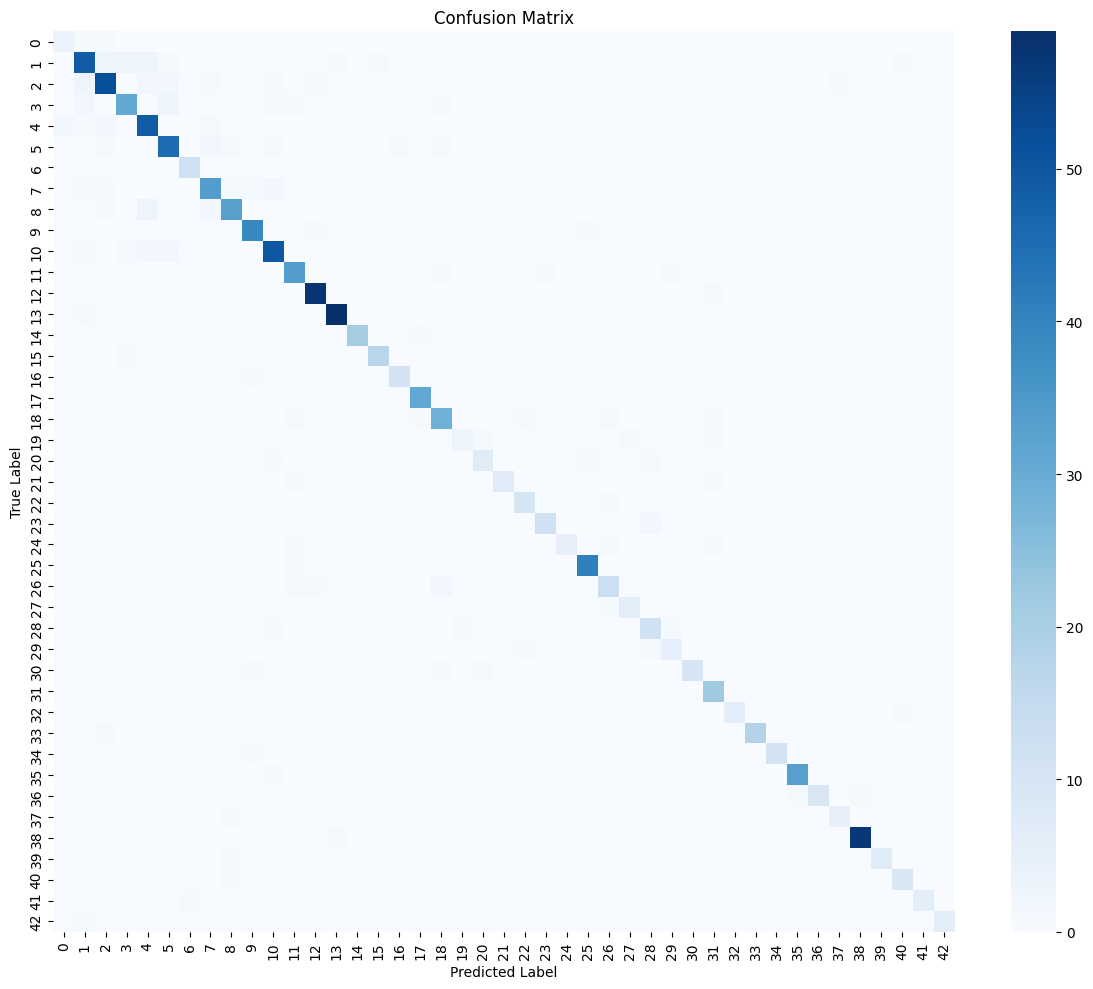

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix (you already have this)
cm = confusion_matrix(y_test, y_pred)

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap='Blues')  # annot=True if you want numbers in cells

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()